In [1]:
using Plots
using Base.Iterators
using LinearAlgebra
using LowRankApprox

In [3]:
D,l = 2000, 0.1

signs = rand((-1,1), ceil(Int, 1/l)+1, D)
shifts = l * rand(D);

signs[1,:].=0
signs[end,:].=0

x = collect(range(0,1,length=1000));

In [4]:
n=3 #positive integer determining the shape
function f(x, a, l)
    return (1 - ((x - a) / l)^2)^n
end
function f_(x, a, l)
    return -n*(1 - ((x - a) / l)^2)^(n-1)*2(x-a)/l^2
end
function f__(x, a, l)
    return 4*(n-1)*n*(x-a)^2*(1 - ((x - a) / l)^2)^(n-2) / l^4  - 2*n*(1 - ((x - a) / l)^2)^(n-1)/l^2
end

f__ (generic function with 1 method)

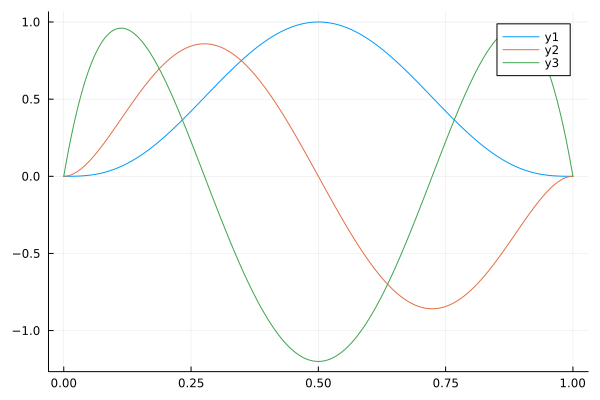

In [5]:
plot(x, f.(x, 0.5, 0.5))
plot!(x, f_.(x, 0.5, 0.5)/4)
plot!(x, f__.(x, 0.5, 0.5)/20)

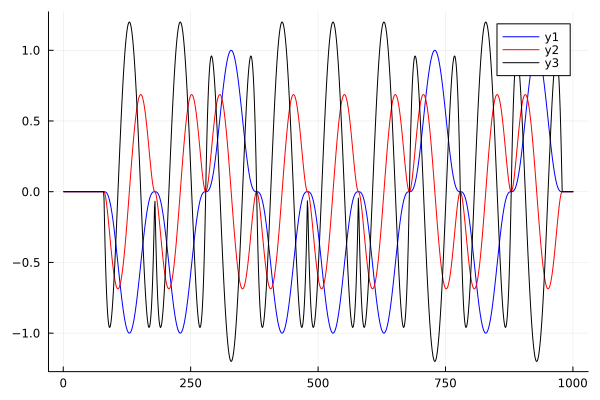

In [6]:
# plot the i'th component of the encoding and its derivatives
i=2
plot(f.(mod.(x .+shifts[i], l), l/2, l/2) .* signs[ceil.(Int, (x.+shifts[i])/l), i], c=:blue) 
plot!(f_.(mod.(x .+shifts[i], l), l/2, l/2) .* signs[ceil.(Int, (x.+shifts[i])/l), i] / 50, c=:red) 
plot!(f__.(mod.(x .+shifts[i], l), l/2, l/2) .* signs[ceil.(Int, (x.+shifts[i])/l), i] / 2000, c=:black) 

In [7]:
function ϕ(x)
    ϕx = zeros(length(x),D)
    for i in 1:D
        ϕx[:,i] .= @. f.(mod.(x .+shifts[i], l), l/2, l/2) .* signs[ceil.(Int, (x.+shifts[i])/l), i]
    end
    return ϕx
end
function ϕ_(x)
    ϕx = zeros(length(x),D)
    for i in 1:D
        ϕx[:,i] .= @. f_.(mod.(x .+shifts[i], l), l/2, l/2) .* signs[ceil.(Int, (x.+shifts[i])/l), i]
    end
    return ϕx
end
function ϕ__(x)
    ϕx = zeros(length(x),D)
    for i in 1:D
        ϕx[:,i] .= @. f__.(mod.(x .+shifts[i], l), l/2, l/2) .* signs[ceil.(Int, (x.+shifts[i])/l), i]
    end
    return ϕx
end

using Statistics
function p(res)
    return res .^2 / mean(res .^2)
end
function wave(res)
    return res /  sqrt(mean(res .^2))
end

wave (generic function with 1 method)

# Some hermitian operators
Goal: checking if they are symmetric, or hermitian if complex

In [27]:
D,l = 5_000, 0.02

x = collect(range(0,1,length=1000))

signs = rand((-1,1), ceil(Int, 1/l)+1, D)
signs[1,:].=0
signs[end,:].=0
shifts = l * rand(D);

In [28]:
ϕx = ϕ(x);
ϕx_ = ϕ_(x);
ϕx__ = ϕ__(x);

impuls: $-i\hbar\nabla$

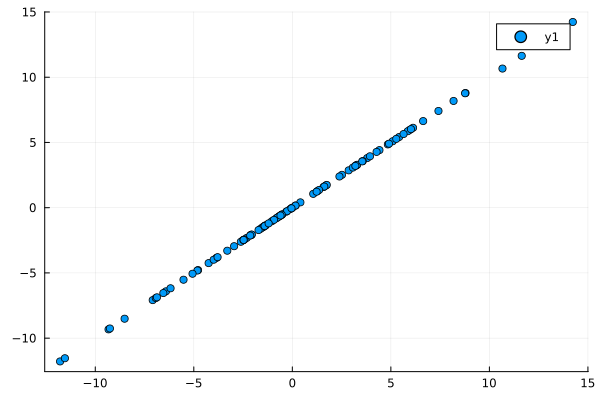

In [29]:
O = ϕx' * ϕx_ / length(x);
scatter(O[1:100], -O'[1:100])

kinetic energy: $- \frac{\hbar^2}{2m} \nabla^2$

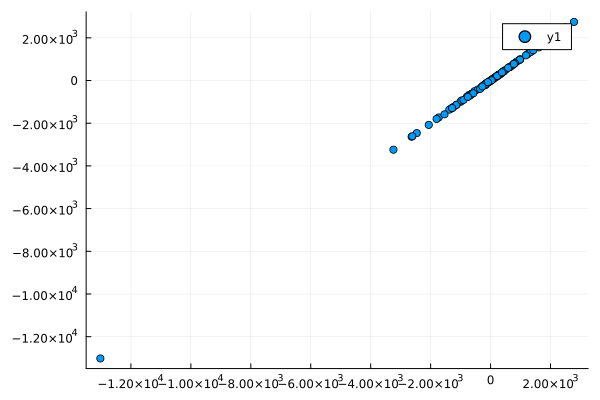

In [30]:
O = ϕx' * ϕx__ / length(x);
scatter(O[1:100], O'[1:100])

harmonic potential:  $\frac{1}{2}m\omega^2 (x-0.5)^2$

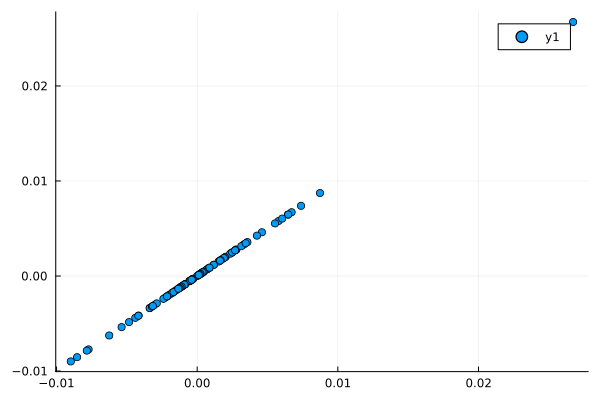

In [31]:
O = ϕx' * ((x .- 0.5).^2 .* ϕx) / length(x)
scatter(O[1:100], O'[1:100])

# The hamiltonian operator

putting $\frac{\hbar^2}{2m} = 1$ and $\frac{1}{2}m\omega^2=10^5$

In [32]:
H1 = - ϕx' * ϕx__ / length(x) / 10^(4)
H2 = ϕx' * ((x .- 0.5).^2 .* ϕx) / length(x);

In [33]:
H = H1 + H2;
H = (H .+ H')/2; #make explicitly symmetric
size(H)

(5000, 5000)

In [34]:
@time E, Ψ = eigen(H) ;
size(E), size(Ψ)

 11.798672 seconds (19 allocations: 573.998 MiB, 0.87% gc time)


((5000,), (5000, 5000))

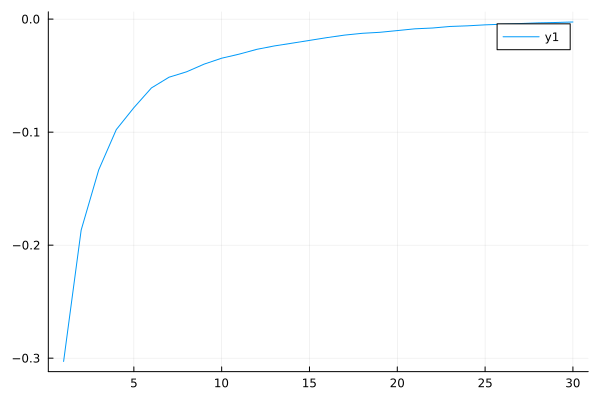

In [35]:
plot(E[1:30])

In [36]:
#@time E, Ψ = pheig(H)
@time E, Ψ = pheig(H, rank=1000)
size(E), size(Ψ)

  6.831627 seconds (10.32 M allocations: 993.057 MiB, 0.96% gc time)


((1000,), (5000, 1000))

In [37]:
function physicist_hermite_polynomial(n, x)
    if n == 0
        return 1.0
    elseif n == 1
        return 2.0 * x
    else
        return 2.0 * x * physicist_hermite_polynomial(n-1, x) - 2.0 * (n-1) * physicist_hermite_polynomial(n-2, x)
    end
end

function normalized_hermite_polynomial(n, x)
    return physicist_hermite_polynomial(n, x) * exp(-x^2 / 2) / sqrt(factorial(n) * sqrt(π))
end

normalized_hermite_polynomial (generic function with 1 method)

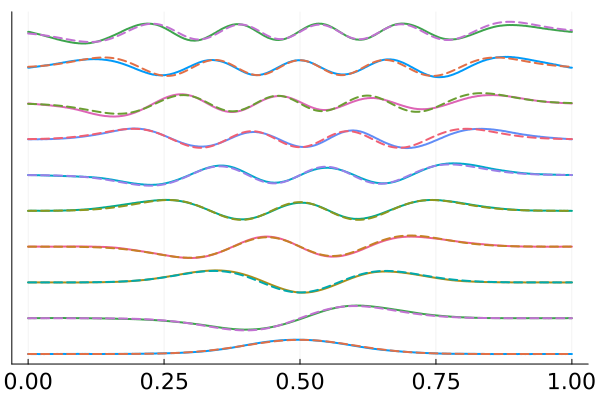

In [39]:
s=6
#c2 = 18 #10^5
c2 = 10
#c2 = 36

pl = plot(legend=false, yticks=nothing, xtickfontsize=15)
for i in 1:10
    w1 = -wave(ϕx*Ψ[:,i])
    w2 = wave(normalized_hermite_polynomial.(i-1, c2*(x .-0.5)))
    sig = sign(mean((w1.*w2)))
    plot!(x, sig*w1 .+i*s, linewidth=2)
    plot!(x, w2 .+ i*s, linestyle=:dash, label="", linewidth=2)
end
pl

In [41]:
savefig(pl,"solutionHO.png")